<a href="https://colab.research.google.com/github/HosseinEbrahimiK/TrajectoryNet-Reproducing/blob/main/CNF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [264]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import sklearn.datasets
import torchdyn; from torchdyn.models import *
from torchdiffeq import odeint
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.distributions import MultivariateNormal

In [265]:
class ChunkSampler(sampler.Sampler):

    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples


In [266]:
class ODEfunc(nn.Module):
  def __init__(self, dim):
    super(ODEfunc, self).__init__()

    self.fc1 = nn.Linear(in_features=dim, out_features=64)
    self.nonLinear1 = nn.Softplus()
    self.fc2 = nn.Linear(in_features=64, out_features=64)
    self.nonLinear2 = nn.Softplus()
    self.fc3 = nn.Linear(in_features=64, out_features=64)
    self.nonLinear3 = nn.Softplus()
    self.fc4 = nn.Linear(in_features=64, out_features=2)
  def forward(self, x):
    out = self.nonLinear1(self.fc1(x))
    out = self.nonLinear2(self.fc2(out))
    out = self.nonLinear3(self.fc3(out))
    out = self.fc4(out)
    return out

In [267]:
def generate_two_moons(num_samples=200, noise=0.1):
  data, _ = sklearn.datasets.make_moons(n_samples=num_samples, noise=noise)
  return data[:,0:2]

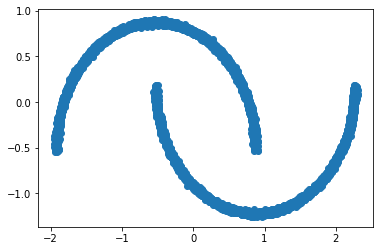

In [268]:
x = generate_two_moons(10000, 0.01)
x = (x-x.mean())/np.std(x)
plt.scatter(x[:,0], x[:,1])
plt.show()

In [276]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X = torch.Tensor(x).to(device)
trainLoader = DataLoader(X, batch_size=64, sampler=ChunkSampler(10000, 0))

In [270]:
def hutch_estimator(x_out, x_in, epsilon):
    jvp = torch.autograd.grad(x_out, x_in, epsilon, allow_unused=True,create_graph=True)[0]
    trJacobian = torch.einsum('bi,bi->b', jvp, epsilon)
    return trJacobian

In [271]:
class CNF(nn.Module):
    def __init__(self, net, trace_estimator=None, noise_dist=None):
        super().__init__()
        self.func = net
        self.trace_estimator = trace_estimator;
        self.noise_dist, self.noise = noise_dist, None
        
    def forward(self, x):
        with torch.set_grad_enabled(True):
            x_in = torch.autograd.Variable(x[:,1:], requires_grad=True).to(x)
            x_out = self.func(x_in).to(x)
            trJ = self.trace_estimator(x_out, x_in, self.noise)
        return torch.cat([-trJ[:, None], x_out], 1) + 0*x

In [272]:
p = MultivariateNormal(torch.zeros(2), torch.eye(2))
cnf = CNF(ODEfunc(2), trace_estimator=hutch_estimator, noise_dist=p)
NODE = NeuralDE(cnf, solver='dopri5', s_span=torch.linspace(0, 1, 2), sensitivity='adjoint', atol=1e-4, rtol=1e-4)

In [273]:
model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=1), NODE).to(device)
prior = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

In [282]:
def train(model, optimizer, num_epochs = 30, print_every=100):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        for t, x in enumerate(trainLoader):

            x_var = Variable(x.to(device))

            traceJacob = model(x_var)
            logprob = prior.log_prob(traceJacob[:,1:]).to(x_var) - traceJacob[:,0]
            loss = -torch.mean(logprob)
            nde.nfe = 0

            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [ ]:
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.iters = 0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        self.iters += 1
        x = batch[0]
        xtrJ = self.model(x)
        logprob = prior.log_prob(xtrJ[:,1:]).to(x) - xtrJ[:,0]
        loss = -torch.mean(logprob)
        nde.nfe = 0
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=2e-3, weight_decay=1e-5)

    def train_dataloader(self):
        return trainLoader

In [285]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-5)
train(model, optimizer)

Starting epoch 1 / 30
t = 100, loss = 2.6040
Starting epoch 2 / 30
t = 100, loss = 3.1775
Starting epoch 3 / 30
t = 100, loss = 2.9800
Starting epoch 4 / 30
t = 100, loss = 2.4616
Starting epoch 5 / 30
t = 100, loss = 2.2878
Starting epoch 6 / 30
t = 100, loss = 2.3272
Starting epoch 7 / 30
t = 100, loss = 2.9071
Starting epoch 8 / 30
t = 100, loss = 2.0831
Starting epoch 9 / 30
t = 100, loss = 2.4186
Starting epoch 10 / 30
t = 100, loss = 2.1471
Starting epoch 11 / 30
t = 100, loss = 2.5512
Starting epoch 12 / 30
t = 100, loss = 2.5306
Starting epoch 13 / 30
t = 100, loss = 3.0604
Starting epoch 14 / 30
t = 100, loss = 1.9157
Starting epoch 15 / 30
t = 100, loss = 1.6080
Starting epoch 16 / 30
t = 100, loss = 3.2367
Starting epoch 17 / 30
t = 100, loss = 3.0134
Starting epoch 18 / 30
t = 100, loss = 2.2455
Starting epoch 19 / 30
t = 100, loss = 2.8184
Starting epoch 20 / 30
t = 100, loss = 2.4835
Starting epoch 21 / 30
t = 100, loss = 2.8229
Starting epoch 22 / 30
t = 100, loss = 3.14

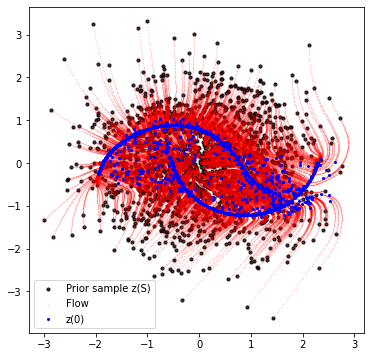

In [287]:
sample = prior.sample(torch.Size([1 << 14]))
# integrating from 1 to 0
model[1].s_span = torch.linspace(1, 0, 2)
new_x = model(sample).cpu().detach()
traj = model[1].trajectory(Augmenter(1, 1)(sample.to(device)), s_span=torch.linspace(1,0,100)).detach().cpu() ; sample = sample.cpu()
traj = traj[:, :, 1:]
n = 2000
plt.figure(figsize=(6,6))
plt.scatter(sample[:n,0], sample[:n,1], s=10, alpha=0.8, c='black')
plt.scatter(traj[:,:n,0], traj[:,:n,1], s=0.2, alpha=0.2, c='red')
plt.scatter(traj[-1,:n,0], traj[-1,:n,1], s=4, alpha=1, c='blue')
plt.legend(['Prior sample z(S)', 'Flow', 'z(0)'])